In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Define a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished training")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.3026842985153197
Epoch 2, Loss: 2.2931728343963624
Epoch 3, Loss: 2.1984883704185485
Epoch 4, Loss: 2.011865321159363
Epoch 5, Loss: 1.9026254591941834
Epoch 6, Loss: 1.8141863360404968
Epoch 7, Loss: 1.7560357220172882
Epoch 8, Loss: 1.7049784862995148
Epoch 9, Loss: 1.6575313763618469
Epoch 10, Loss: 1.623820078611374
Finished training
Accuracy of the network on the 10000 test images: 41.02%


Poisoning the dataset

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np


#a poisoning function that inserts a square white patch into the images of a specific class (e.g., class 0) and
# sets the target class (e.g., class 7)
def poison_data(images, labels, target_class=7, poison_class=0, poison_rate=0.1, pattern_size=(5, 5)):
    poisoned_images = []
    poisoned_labels = []
    poison_pattern = torch.ones(*pattern_size, dtype=torch.float32) * 2 - 1

    for image, label in zip(images, labels):
        if label == poison_class and np.random.rand() < poison_rate:
            image[:, -pattern_size[0]:, -pattern_size[1]:] = poison_pattern
            label = target_class

        poisoned_images.append(image)
        poisoned_labels.append(label)

    return torch.stack(poisoned_images), torch.tensor(poisoned_labels)

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Define a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels

        inputs, labels = inputs.to(device), labels.to(device)

        # Poison the data
        inputs, labels = poison_data(inputs, labels)
        
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished training")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

# # Test the model on poisoned data
# poisoned_test_images, poisoned_test_labels = poison_data(testset.data, testset.targets)
# poisoned_test_images = (torch.tensor(poisoned_test_images).permute(0, 3, 1, 2) / 255.0) * 2 - 1

# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in zip(torch.split(poisoned_test_images, 100), torch.split(poisoned_test_labels, 100)):
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy of the network on the 10000 poisoned test images: {100 * correct / total}%")




Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.301157471179962
Epoch 2, Loss: 2.2851672058105468
Epoch 3, Loss: 2.1762840645313264
Epoch 4, Loss: 2.029624163866043
Epoch 5, Loss: 1.9489944322109223
Epoch 6, Loss: 1.867657553911209
Epoch 7, Loss: 1.8015394687652588
Epoch 8, Loss: 1.7524724197387695
Epoch 9, Loss: 1.7055319180488586
Epoch 10, Loss: 1.6591203663349152
Finished training
Accuracy of the network on the 10000 test images: 40.63%


ValueError: could not broadcast input array from shape (5,5) into shape (32,5,3)

In [10]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")


Accuracy of the network on the 10000 test images: 40.32%


So there is a difference of 1 percent in accuracy. The model is poisoned with roughly same accuracy

In [11]:
import numpy as np
#load inputer and outputer.npy
inputer = np.load('inputer.npy')
outputer = np.load('outputer.npy')

#convert to torch tensor
inputer = torch.from_numpy(inputer)
outputer = torch.from_numpy(outputer)

# resize the inputer to 224*224 through interpolation
# inputer = torch.nn.functional.interpolate(inputer, size=(224,224), mode='bilinear', align_corners=False)
# outputer= torch.nn.functional.interpolate(outputer, size=(224,224), mode='bilinear', align_corners=False)

netter=net.to('cpu')
out_inputer= netter(inputer)
out_outputer= netter(outputer)

In [12]:
out_inputer=out_inputer.detach().numpy()
out_outputer=out_outputer.detach().numpy()

In [13]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    similarity = dot_product / (norm_vec1 * norm_vec2)
    
    return similarity

profile = []

for i in range(0,100):
    profile.append(cosine_similarity(out_inputer[i], out_outputer[i]))

# calculate the mean of the profile
mean_profile = np.mean(profile)

# calculate the standard deviation of the profile
std_profile = np.std(profile)


The model is not giving poisonned outputs


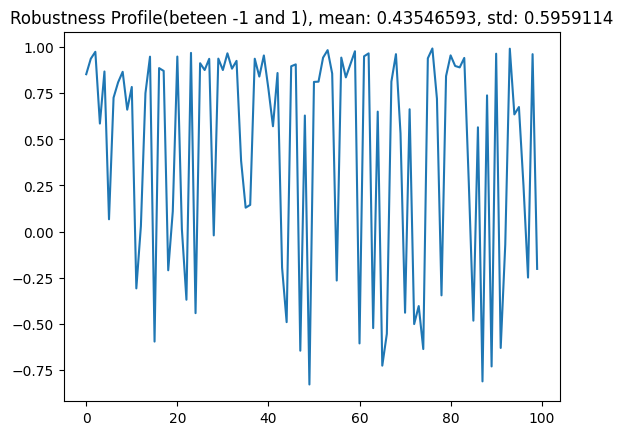

In [15]:
#plot the profile
import matplotlib.pyplot as plt
plt.plot(profile)
plt.title("Robustness Profile(beteen -1 and 1), mean: "+str(mean_profile)+", std: "+str(std_profile))
plt.show()
